In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from bs4 import BeautifulSoup
from urllib.request import urlopen
import pandas as pd

In [2]:
#data from wikipedia each state
html = urlopen('https://en.wikipedia.org/wiki/Growth_of_wind_power_in_the_United_States')
soup = BeautifulSoup(html.read(),'html.parser')
tables = soup.find_all('table', {'class':'wikitable'})

#Search through the tables for the one with the headings we want
for table in tables:
    ths = table.find_all('th')
    headings = [th.text.strip() for th in ths]
    if headings[:4] == ['State', '2015']:
        break
        
# Extract the columns we want and write to a semicolon-delimited text file.
column_list = ['State','2015','2014','2013','2012','2011', '2010', '2009','2008',
              '2007','2006','2005','2004','2003', '2002', '2001','2000']
wind = pd.DataFrame(index = list(range(41)), columns = column_list)
data_list = list()
for tr in table.find_all('tr'):
    tds = tr.find_all('td')
    if not tds:
        continue
    Data = [td.text.strip() for td in tds]
    data_list.append(Data)

data_list = np.array(data_list)
count = 0 
for col in column_list:
    wind[col] = data_list[:,count]
    count += 1
#energy.to_csv (r'C:\Users\yanbo_000\Desktop\143Project\energy_consumpton_USA.csv', index = None, header=True)
html.close()
wind.index=wind['State']
wind = wind.drop('State',axis=1)

In [3]:
def convert_to_list(pd):
    '''
        convert a string list to float list
    '''
    assert isinstance(pd, list)
    for i in range(len(pd)):
        string = str(pd[i])
        num = string.replace('%','')
        num = num.replace(',','')
        num = float(num)
        pd[i] = num
    return pd

In [ ]:
windproduction = {
'New Jersey':  549,
'Rhode Island':   59,
'Massachusetts':   1197,
'Connecticut':    922,
'Maryland':   814,
'New York':    6711,
'Delaware':    31,
'Florida':     682,
'Ohio':  3046,
'Pennsylvania':  8368,
'Illinois':    4883,
'California':  30024,
'Hawaii':  2602,
'Virginia':    3657,
'Michigan':    1181,
'Indiana':    2394,
'North Carolina':  3037,
'Georgia':     1988,
'Tennessee':   5745,
'New Hampshire':   1741,
'South Carolina':  1889,
'Louisiana':   2423,
'Kentucky':   4255,
'Wisconsin':  2287,
'Washington':  27249,
'Alabama':     4103,
'Missouri':    7198,
'Texas':   3006,
'West Virginia':   4408,
'Vermont':     1710,
'Minnesota':  1255,
'Mississippi':   2211,
'Iowa':  2818,
'Arkansas':    6093,
'Oklahoma':    3016,
'Arizona':     1303,
'Colorado':    7789,
'Maine':  3916,
'Oregon':  18184,
'Kansas':  2508,
'Utah':  3528,
'Nebraska':    3142,
'Nevada':  846,
'Idaho':   18758,
'New Mexico':  1363,
'South Dakota':  1047,
'North Dakota':  347,
'Montana':     14547,
'Wyoming':      4445,
'Alaska':     23676}

In [17]:
windgenereation = dict()
states = wind.index
production = convert_to_list(list(wind['2015']))
print(len(states))
count = 0
for state in states:
    windgenereation[state] = production[count]
    count += 1
windgenereation['Alabama'] = 0.0
windgenereation['Arkansas'] = 0.0
windgenereation['Florida'] = 0.0
windgenereation['Georgia'] = 0.0
windgenereation['Alabama'] = 0.0
windgenereation['Kentucky'] = 0.0
windgenereation['Louisiana'] = 0.0
windgenereation['South Carolina'] = 0.0
windgenereation['Mississippi'] = 0.0
windgenereation['Virginia'] = 0.0
print(len(windgenereation))

41
50


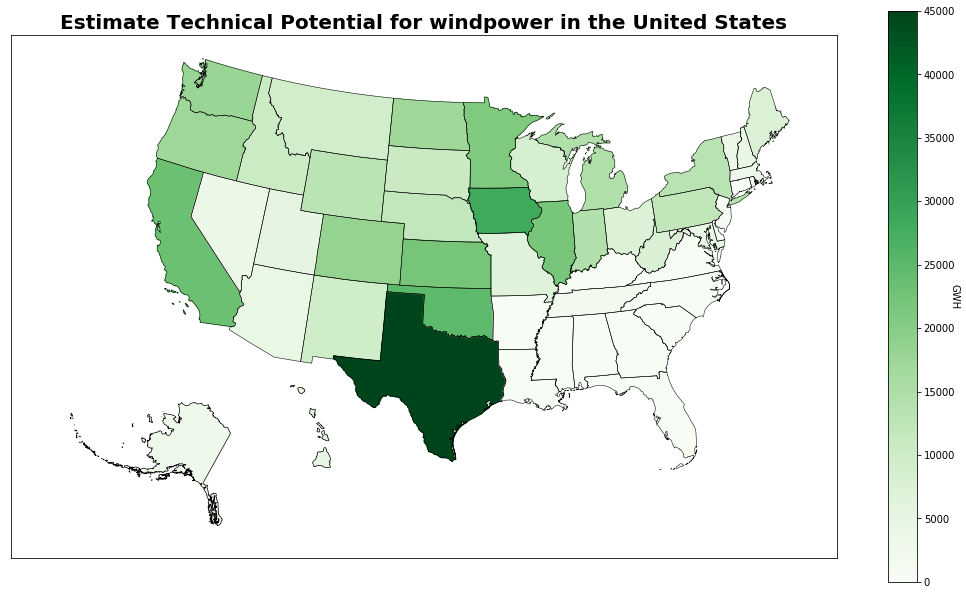

In [20]:
def plot_map_hydro_potential(hydroPotential): 
    '''
        projection: Lambert Conformal Projection (lcc)
        llcrnrlon: longitude of lower left hand corner of the desired map domain (-119)
        llcrnrlat:latitude of lower left hand corner of the desired map domain (22)
        urcrnrlon:longitude of upper right hand corner of the desired map domain (64)
        urcrnrlat:latitude of upper right hand corner of the desired map domain (49)
        lon_0:center of desired map domain (-95).
        resolution: high
    '''
    assert isinstance(hydroPotential, dict)
    assert len(hydroPotential) == 50
    fig = plt.figure(figsize=(18.5, 10.5))
    m = Basemap(llcrnrlon=-125,llcrnrlat=15,urcrnrlon=-60,urcrnrlat=49,
            projection='lcc',lat_1=33,lat_2=45,lon_0=-95,resolution='l')
    # draw state boundaries.
    # data from U.S Census Bureau
    shp_info = m.readshapefile('cb_2018_us_state_5m','states',drawbounds=True)
    # Energy comsumption by 2016
    # https://www.eia.gov/state/seds/sep_sum/html/pdf/sum_btu_1.pdf
    # choose a color for each state based on population density.
    colors={}
    statenames=[]
    cmap = plt.cm.Greens_r # use 'hot' colormap
    vmin = 0; vmax = 45000 # set range.
    for shapedict in m.states_info:
        statename = shapedict['NAME']
        # skip DC and Puerto Rico.
        if statename not in ['District of Columbia','Puerto Rico', 'United States Virgin Islands',\
                             'Guam','Commonwealth of the Northern Mariana Islands','American Samoa']:
            pop = hydroPotential[statename]
            # calling colormap with value between 0 and 1 returns
            # rgba value.  Invert color range (hot colors are high
            # population), take sqrt root to spread out colors more.
            colors[statename] = cmap(1.-np.sqrt((pop-vmin)/(vmax-vmin)))[:3]
        statenames.append(statename)
    # cycle through state names, color each one.
    ax = plt.gca() # get current axes instance
    for nshape,seg in enumerate(m.states):
        # skip DC and Puerto Rico.
        if statenames[nshape] not in ['District of Columbia','Puerto Rico', 'United States Virgin Islands',\
                             'Guam','Commonwealth of the Northern Mariana Islands','American Samoa']:
            # Offset Alaska and Hawaii to the lower-left corner. 
            if statenames[nshape] == 'Alaska':
            # Alaska is too big. Scale it down to 35% first, then transate it. 
                seg1 = list(map(lambda x : (0.35 * x[0] + 1100000, 0.35 * x[1]-1300000), seg))
                color = rgb2hex(colors[statenames[nshape]]) 
                poly = Polygon(seg1,facecolor=color,edgecolor='black',linewidth = 0.7)
                ax.add_patch(poly)
            if statenames[nshape] == 'Hawaii':
                seg1 = list(map(lambda x: (x[0] + 5000000, x[1]-1400000), seg))
                color = rgb2hex(colors[statenames[nshape]]) 
                poly = Polygon(seg1,facecolor=color,edgecolor='black',linewidth = 0.7)
                ax.add_patch(poly)
            else:   
                color = rgb2hex(colors[statenames[nshape]]) 
                poly = Polygon(seg,facecolor=color,edgecolor=color)
                ax.add_patch(poly)

    # Create a colorbar
    sm = plt.cm.ScalarMappable(cmap='Greens' , norm=plt.Normalize(vmin=0, vmax=45000))
    sm._A = []

    cbar = fig.colorbar(sm)
    cbar.set_label('GWH', rotation=270)

    plt.title('Estimate Technical Potential for windpower in the United States',fontsize = 20, fontweight='bold')
    plt.show()
plot_map_hydro_potential(windgenereation)